In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import deque



In [2]:
# Load the data
df = pd.read_csv('dataResearch.csv', index_col=0, usecols=lambda column: column not in ['SL.', 'Station', 'Year', 'Month', 'Temperature (maximum)', 'Temperature(Average)', 'Rainfall(mm)', 'Humidity(percentage)'])
df

,Temperature(minimum)
Date,
1/1/1970,11.37
1/2/1970,14.07
1/3/1970,17.86
1/4/1970,21.65
1/5/1970,23.08
...,...
1/8/2022,26.20
1/9/2022,25.57
1/10/2022,23.47


In [3]:
# Separate date and temperature columns
df['Date'] = pd.to_datetime(df.index)  # Assuming your date information is in the index
df = df[['Date', 'Temperature(minimum)']].copy()  # Make a copy to avoid the SettingWithCopyWarning

# Print the separated data
print("Separated Data:")
print(df.head())


Separated Data:
               Date  Temperature(minimum)
Date                                     
1/1/1970 1970-01-01                 11.37
1/2/1970 1970-01-02                 14.07
1/3/1970 1970-01-03                 17.86
1/4/1970 1970-01-04                 21.65
1/5/1970 1970-01-05                 23.08


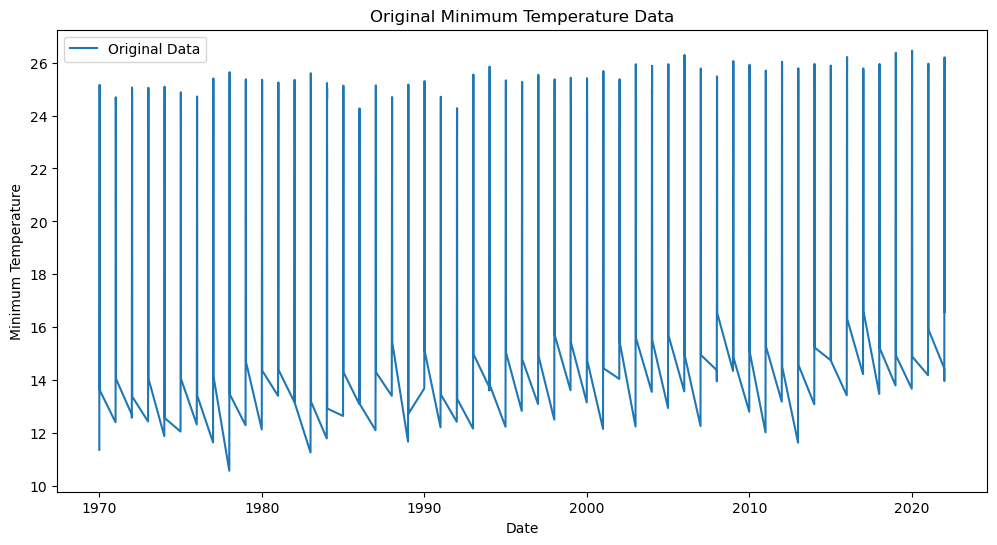

In [4]:
# Plot the original data
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Temperature(minimum)'], label='Original Data')
plt.title('Original Minimum Temperature Data')
plt.xlabel('Date')
plt.ylabel('Minimum Temperature')
plt.legend()
plt.show()


In [5]:
# Normalize the data
scaler = MinMaxScaler()
df['Temperature_Scaled'] = scaler.fit_transform(df[['Temperature(minimum)']])


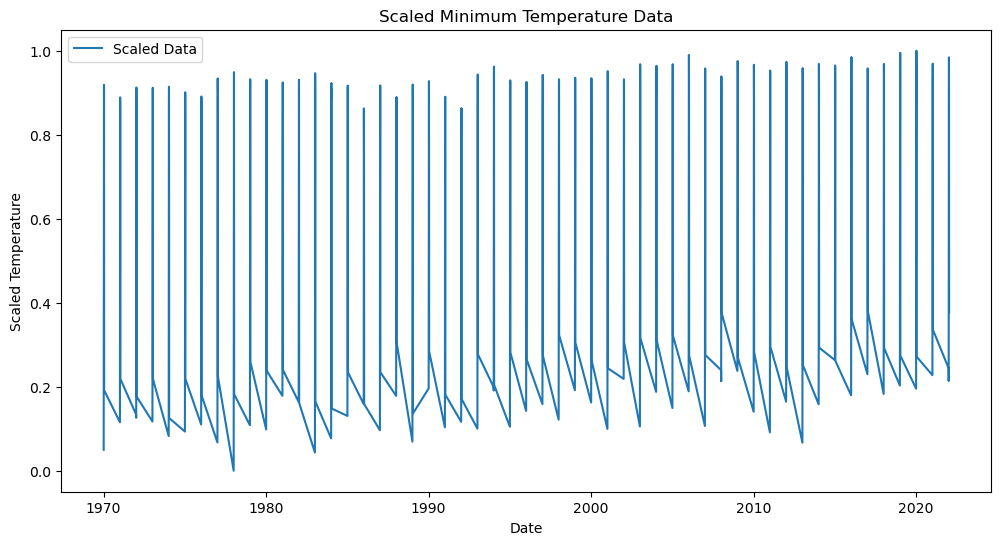

In [6]:
# Plot the scaled data
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Temperature_Scaled'], label='Scaled Data')
plt.title('Scaled Minimum Temperature Data')
plt.xlabel('Date')
plt.ylabel('Scaled Temperature')
plt.legend()
plt.show()

In [7]:

# Prepare the data for training
sequence_length = 12  # Adjust this based on your preference and the periodicity of the data
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df['Temperature_Scaled'].values[i:i + sequence_length])
    y.append(df['Temperature_Scaled'].values[i + sequence_length])

X = np.array(X)
y = np.array(y)

In [8]:
# Convert data to PyTorch tensors
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(y).float()


In [9]:
print("Size of X_train:", len(X_train))

Size of X_train: 624


In [10]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
# Instantiate the model, loss function, and optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [11]:
# Instantiate the model, loss function, and optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [12]:
# Train the model
epochs = 100
for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

        # Ensure the shapes of seq and labels are compatible
        seq = seq.view(-1, 1, 1)  # Adjust the dimensions if needed
        labels = labels.view(-1, 1)  # Adjust the dimensions if needed

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(f'Epoch {i} Loss: {single_loss.item()}')

C:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.0007529607973992825
Epoch 10 Loss: 0.004091958981007338
Epoch 20 Loss: 0.004858505912125111
Epoch 30 Loss: 0.005078672431409359
Epoch 40 Loss: 0.0052239964716136456
Epoch 50 Loss: 0.005330860149115324
Epoch 60 Loss: 0.005351333878934383
Epoch 70 Loss: 0.005323934368789196
Epoch 80 Loss: 0.005169607233256102
Epoch 90 Loss: 0.0049171121791005135


In [ ]:
# Evaluate the model on the validation set
model.eval()
y_pred = []
for seq in X_train:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        y_pred.append(model(seq).item())


In [159]:
# Inverse transform the predicted values
y_pred = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))

# Calculate and print performance metrics
mse_train = mean_squared_error(y_train_inv, y_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train_inv, y_pred)

print(f'Mean Squared Error on Training Set: {mse_train}')
print(f'Root Mean Squared Error on Training Set: {rmse_train}')
print(f'R-squared (R2) on Training Set: {r2_train}')


Mean Squared Error on Training Set: inf
Root Mean Squared Error on Training Set: inf
R-squared (R2) on Training Set: -inf


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:446: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:927: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0, dtype=np.float64)


In [16]:
# Initialize future_seq with the last sequence from the training data
future_seq = deque(X_train[-sequence_length:].tolist(), maxlen=sequence_length)

predictions_2023_2024 = []
# Convert future_seq to the correct shape using torch.unsqueeze
for _ in range(24):
    future_seq_tensor = torch.unsqueeze(torch.from_numpy(np.array(future_seq)), dim=0).float()
    # Reinitialize the hidden state for each prediction
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                         torch.zeros(1, 1, model.hidden_layer_size))
    prediction = model(future_seq_tensor).item()
    predictions_2023_2024.append(prediction)
    future_seq.append(prediction)


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 144

In [17]:
# Convert the list to a NumPy array before calling flatten
predictions_2023_2024_array = np.array(predictions_2023_2024)

# Create a DataFrame with dates and the predicted values for 2023 and 2024
index_2023_2024 = pd.date_range(start=df['Date'].iloc[-1] + pd.DateOffset(months=1), periods=len(predictions_2023_2024), freq='M')
df_predictions_2023_2024 = pd.DataFrame(data={'Temperature(minimum)': predictions_2023_2024_array.flatten()}, index=index_2023_2024)


In [ ]:
print(predictions_2023_2024_array)


In [ ]:
# Print the predicted values
print("\nPredicted Minimum Temperatures for 2023 and 2024:")
print(df_predictions_2023_2024)


In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Temperature_Scaled'], label='Original Data (Scaled)')
plt.plot(index_2023_2024, predictions_2023_2024, label='Predicted Minimum Temperature (2023-2024)', linestyle='--')
plt.title('Minimum Temperature Time Series Prediction (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Scaled Minimum Temperature')
plt.legend()
plt.show()

## Problem: Finding unexpected Error While train the machine And Accuracy not upto the mark..

### Expected outcome: Train the model for time series analysis with Date and Temperature(minimum) and finding better accuracy with 2 years prediction data (2023 and 2024) per month basis..